In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)
import sys
sys.setrecursionlimit(10000)  



In [50]:
import os
import psutil

pid = os.getpid()
process = psutil.Process(pid)
mem_info = process.memory_info()

print(f"Используется памяти процессом Jupyter: {mem_info.rss / (1024 ** 3):.2f} ГБ")



Используется памяти процессом Jupyter: 7.32 ГБ


In [8]:
# Загрузка сырых данных

hits_path = "C:/Users/Ekaterina/sber_de/de_for_sber/data/raw/ga_hits.csv"
df_hits = pd.read_csv(hits_path)

# Просмотр данных
df_hits.head()


,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [9]:
#Общая информация
print(df_hits.info())
print(df_hits.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB
None
           hit_time    hit_number  event_value
count  6.566148e+06  1.572647e+07          0.0
mean   2.091050e+05  2.356715e+01          NaN
std    4.032110e+05  2.887713e+01          NaN
min    0.000000e+00  1.000000e+00          NaN
25%    2.412000e+04  7.000000e+00          NaN
50%    8.994100e+04  1.500000e+01          NaN
75%    2.195352e+05  2.900000e+01          NaN
max    1.315688e+07  5.000000e+02          NaN


In [10]:
# 1. Анализ пропущенных данных
missing_data = df_hits.isnull().sum()  # Считаем количество пропущенных значений в каждом столбце
missing_percentage = (missing_data / len(df_hits)) * 100  # Процент пропущенных значений
missing_data = pd.DataFrame({"Missing Data": missing_data, "Percentage": missing_percentage})
print(missing_data)  # Выводим информацию о пропущенных данных


                Missing Data  Percentage
session_id                 0    0.000000
hit_date                   0    0.000000
hit_time             9160322   58.247795
hit_number                 0    0.000000
hit_type                   0    0.000000
hit_referer          6274804   39.899634
hit_page_path              0    0.000000
event_category             0    0.000000
event_action               0    0.000000
event_label          3760184   23.909905
event_value         15726470  100.000000


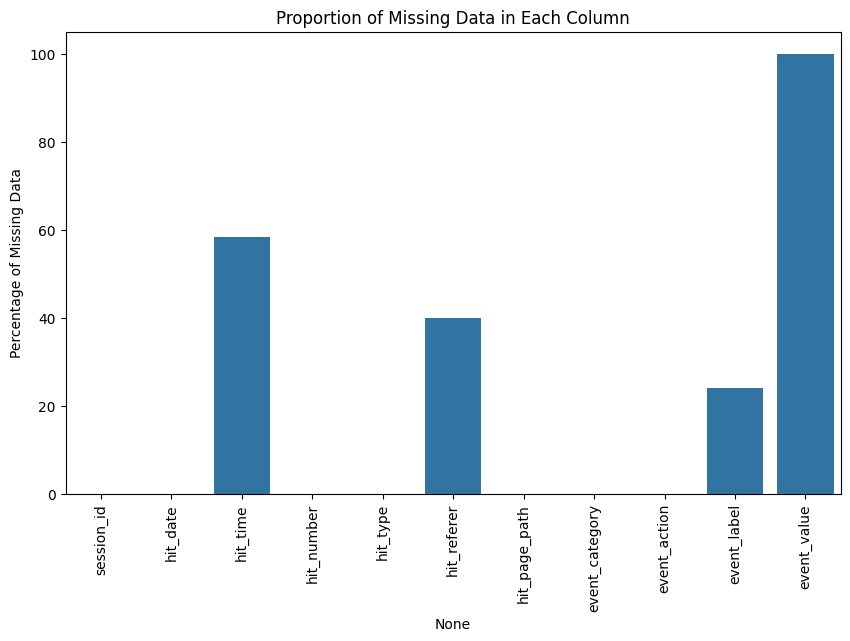

In [11]:
# Визуализируем пропущенные данные
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data["Percentage"])
plt.title("Proportion of Missing Data in Each Column")
plt.xticks(rotation=90)
plt.ylabel("Percentage of Missing Data")
plt.show()

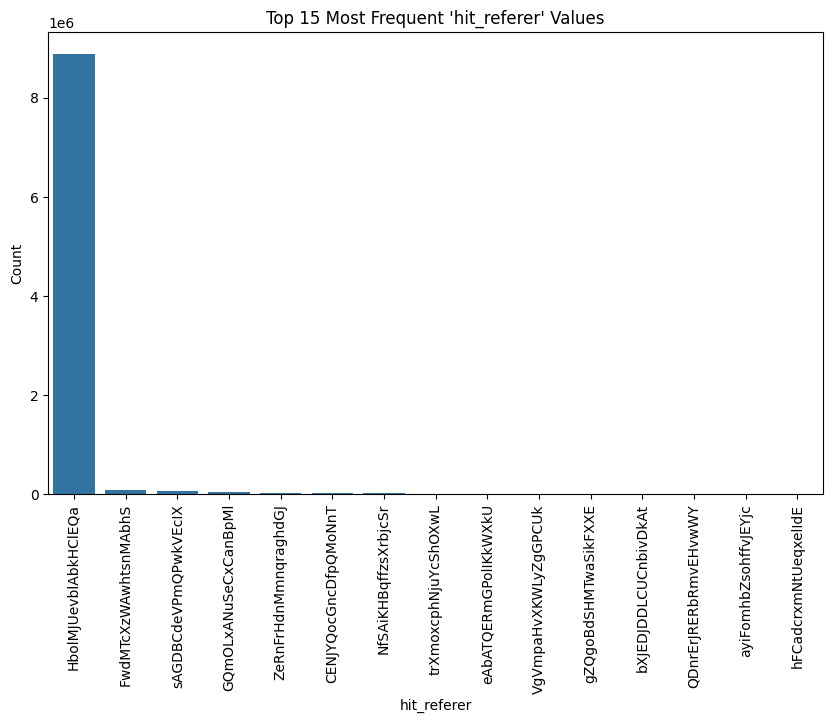

In [12]:
#Анализ распределения значений в атрибуте, выделяем только первые 15 часто встречающихся 
top_15_hit_referer = df_hits['hit_referer'].value_counts().nlargest(15)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_hit_referer.index, y=top_15_hit_referer.values)
plt.title("Top 15 Most Frequent 'hit_referer' Values")
plt.xticks(rotation=90)
plt.xlabel("hit_referer")
plt.ylabel("Count")
plt.show()

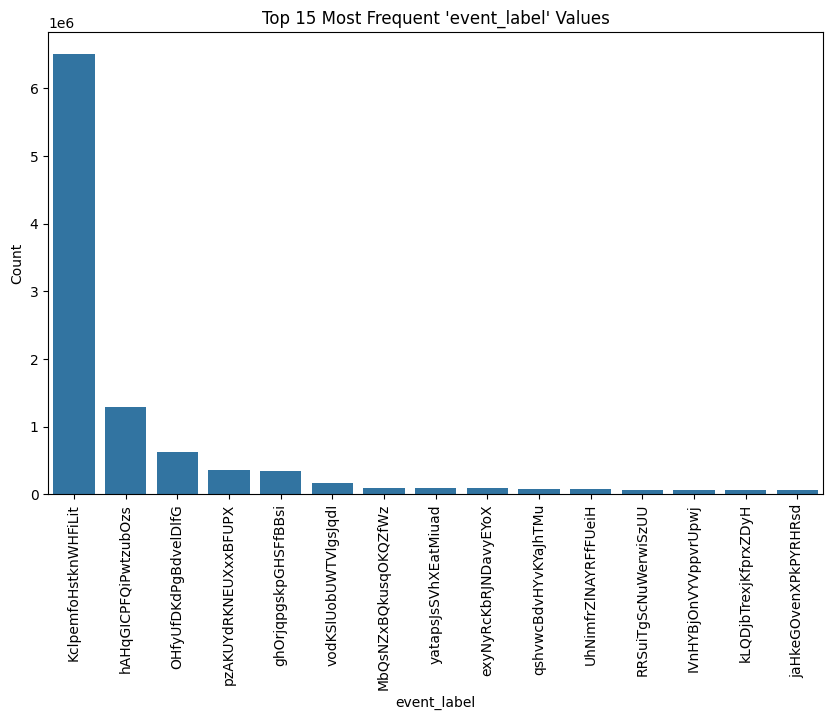

In [13]:
##Анализ распределения значений в атрибуте, выделяем только первые 15 часто встречающихся 
top_15_event_label = df_hits['event_label'].value_counts().nlargest(15)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_event_label.index, y=top_15_event_label.values)
plt.title("Top 15 Most Frequent 'event_label' Values")
plt.xticks(rotation=90)
plt.xlabel("event_label")
plt.ylabel("Count")
plt.show()

In [14]:
#Атрибут состоит из одинаковых значений, будет удален 
df_hits['hit_type'].value_counts()

hit_type
event    15726470
Name: count, dtype: int64

In [15]:
#Пустой атрибут, будет удален
df_hits['event_value'].value_counts()

Series([], Name: count, dtype: int64)

In [16]:
#Удаляем неинформативные колонки 
df_hits = df_hits.drop(columns=['hit_time', 'event_value', 'hit_type'])



In [17]:
#Заполняем пропуски
df_hits['hit_referer'] = df_hits['hit_referer'].fillna('unknown')
df_hits['event_label'] = df_hits['event_label'].fillna('unknown')
    

In [18]:
#Меням тип колонки на дату 
df_hits['hit_date'] = pd.to_datetime(df_hits['hit_date'], errors='coerce')

In [19]:
#Меняем на строки, чтобы не путал с float
df_hits["session_id"] = df_hits["session_id"].astype(str)

In [20]:
#Cоздаем уникальный ключ
df_hits['hit_id'] = df_hits['session_id'].astype(str) + '_' + df_hits['hit_number'].astype(str)

In [21]:
#И находим там дубликаты
duplicates = df_hits[df_hits.duplicated(subset='hit_id', keep=False)]

In [22]:
duplicates['hit_id'].value_counts()

hit_id
3342683090018960564.1632259699.1632259699_50    2
2482311934159544567.1632297202.1632297202_7     2
2493081100797813030.1632313646.1632313646_6     2
2605321305050539964.1632331709.1632331709_3     2
2415139362909660821.1632315035.1632315035_7     2
                                               ..
3301019858548493165.1632308082.1632308082_7     2
3243563014423259064.1632315320.1632315320_5     2
3211301925925116359.1632328137.1632328137_7     2
3138557137119824849.1632324562.1632324562_5     2
3134152304560373247.1632304641.1632304641_7     2
Name: count, Length: 225862, dtype: int64

In [23]:
#Меняю строки, где было unknown в hit_referer, event_label на Nan, чтобы потом отсортировать, будет заметно неинформативные строки опустились
#ниже, их я фиксирую и удаляю из основного сета
duplicates = duplicates.replace('unknown', pd.NA)
duplicates = duplicates.sort_values(
    by=['hit_id', 'hit_referer', 'event_label'],  
    ascending=[True, True, True])
to_drop = duplicates.drop_duplicates(subset='hit_id', keep='last')
indexes_to_drop = to_drop.index
df_cleaned = df_hits.drop(indexes_to_drop)

In [24]:
#Пример
duplicates.head()

,session_id,hit_date,hit_number,hit_referer,hit_page_path,event_category,event_action,event_label,hit_id
13612179,1000457743553563495.1632406504.1632406504,2021-09-23,3,HbolMJUevblAbkHClEQa,sberauto.com/cars/6afb1543?rental_page=rental_car,card_web,view_card,KclpemfoHstknWHFiLit,1000457743553563495.1632406504.1632406504_3
13161439,1000457743553563495.1632406504.1632406504,2021-09-23,3,<NA>,sberauto.com/cars/6afb1543?rental_page=rental_car,card_web,view_card,<NA>,1000457743553563495.1632406504.1632406504_3
10458798,1000457743553563495.1632406504.1632406504,2021-09-23,4,HbolMJUevblAbkHClEQa,sberauto.com/cars/6afb1543?rental_page=rental_car,card_web,view_new_card,KclpemfoHstknWHFiLit,1000457743553563495.1632406504.1632406504_4
11809677,1000457743553563495.1632406504.1632406504,2021-09-23,4,<NA>,sberauto.com/cars/6afb1543?rental_page=rental_car,card_web,view_new_card,<NA>,1000457743553563495.1632406504.1632406504_4
11359619,1000457743553563495.1632406504.1632406504,2021-09-23,5,HbolMJUevblAbkHClEQa,sberauto.com/cars/6afb1543?rental_page=rental_car,card_web,view_card,KclpemfoHstknWHFiLit,1000457743553563495.1632406504.1632406504_5


In [25]:
df_cleaned.isnull().sum()

session_id        0
hit_date          0
hit_number        0
hit_referer       0
hit_page_path     0
event_category    0
event_action      0
event_label       0
hit_id            0
dtype: int64

In [26]:
#Проведн анализ, обработан сет
df_cleaned.columns

Index(['session_id', 'hit_date', 'hit_number', 'hit_referer', 'hit_page_path',
       'event_category', 'event_action', 'event_label', 'hit_id'],
      dtype='object')

In [46]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15500608 entries, 0 to 15726469
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   session_id      object        
 1   hit_date        datetime64[ns]
 2   hit_number      int64         
 3   hit_referer     object        
 4   hit_page_path   object        
 5   event_category  object        
 6   event_action    object        
 7   event_label     object        
 8   hit_id          object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 1.2+ GB


In [ ]:
df_cleaned.to_pickle("C:/Users/Ekaterina/sber_de/de_for_sber/data/processed/processed_hits.pkl")

In [34]:
#загружаем все айди из сессий
ids_in_sessions = pd.read_csv("C:/Users/Ekaterina/sber_de/de_for_sber/data/processed/ids_in_sessions.csv")
len(ids_in_sessions)

1860042

In [35]:
#берем все айди из хитс
ids_in_hits = df_cleaned['session_id']
len(ids_in_hits)

15500608

In [44]:
#ищем несовпадения по айди, в хитс сузествуют айди, которых нет в сессиях
missing_ids = (ids_in_hits[~ids_in_hits.isin(ids_in_sessions['session_id'])]).to_list()


In [45]:
len(missing_ids)

41226

In [48]:
# Находим индексы строк, где айди не совпадают
indexes_to_drop = df_cleaned[df_cleaned['session_id'].isin(missing_ids)].index


In [49]:
# Удаляем эти строки
hits_filtered = df_cleaned.drop(index=indexes_to_drop)


In [52]:
hits_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15459382 entries, 0 to 15726469
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   session_id      object        
 1   hit_date        datetime64[ns]
 2   hit_number      int64         
 3   hit_referer     object        
 4   hit_page_path   object        
 5   event_category  object        
 6   event_action    object        
 7   event_label     object        
 8   hit_id          object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 1.2+ GB


In [55]:
hits_filtered.to_pickle("C:/Users/Ekaterina/sber_de/de_for_sber/data/processed/filtered_processed_hits.pkl")